<a href="https://colab.research.google.com/github/MahshidAlimi/ComputerVision/blob/master/Portrait_Segmentation_using_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

I have both performed Portrait Segmentation and Smile classification on the CelebA dataset. Section A of the notebook is the transfer learning style portrait segmentation using the Mask RCNN model and utilising pre-trained COCO weights. On section B of the notebook, I used Inception V3 network for smile classification task. The training set was augmented before training, the validation set was used for hyperparameter tuning and the weights of the best model trained were saved. These weights were used during test time to predict smiling images on the corresponding test set. 

Portrait segmentation can be described as detection and segmentation of (often) the biggest object within an image. KNN matting, Bayesian matting and Closed-form matting models are few examples of pedestrian techniques that are often used and result into reasonable accuracies for the task at hand. There are two main drawbacks of models of this type for today's Machine Learning demands: Firstly, these models are not capable of detecting the label of the object in the image e.g. whether the image depicts a cat or a person. Secondly, these models require already created masks which act as ground truth that the model needs to predict. This requires defining which pixels belong to the background and which to the foreground. The CelebA dataset does not come with a set of pre-defined masks and hence going through the 220,599 images and creating the ground truth masks is not only labour intensive but also is computationally quite expensive which is beyond the scope of this project. Hence, I have chosen to use transfer learning from a pre-trained Mask RCNN model, which is considered to be the current state-of-the-art instance segmentation technique. It is not only capable of predicting the label of the object but also is capable of segmentation of the object without the need of labeling the pixels within an image. Mask RCNN is capable of detection of plethora of objects, however we only need to detect a person in the CelebA dataset hence the pre-trained COCO weights are used for this purpose. No model is trained from scratch for the portrait segmentation task but COCO weights are used to facilitate transfer learning.  


Smile classification on the other hand was computationally quite light as the CelebA dataset was already labelled. The motivation behind performing the smile classification task alongside portrait segmentation was to demonstrate my understanding of training and testing a model by removing the fully connected classifier of Inception V3 architecture and replacing it by a custom classification layer.


# Importing Libraries and Loading CelebA dataset

We will firstly start by importing the CelebA dataset from the Kaggle website. Cloning Mask RCNN model from github. Importing relevant libraries and setting global variables.  Please skip to the "Data Exploration" section.

In [0]:
# fistly uplaod kaggle.json file from the local disk
# cloning the MASK RCNN github

!git clone https://github.com/huuuuusy/Mask-RCNN-Shiny.git

Cloning into 'Mask-RCNN-Shiny'...
remote: Enumerating objects: 82, done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82
Unpacking objects: 100% (82/82), done.


In [0]:
!git clone https://github.com/kohpangwei/influence-release.git

Cloning into 'influence-release'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59
Unpacking objects: 100% (59/59), done.
Checking out files: 100% (42/42), done.


In [0]:
cd Mask-RCNN-Shiny/

/content/Mask-RCNN-Shiny


In [0]:
import pandas as pd
from PIL import Image
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import copy

import os
import sys
from samples import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn.model import log


from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD


from IPython.core.display import display, HTML
from io import BytesIO
import base64
from imutils import paths

Using TensorFlow backend.


In [0]:
cd ..

/content


In [0]:
# Importing the Celeba dataset from kaggle.
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.21G/1.21G [00:35<00:00, 35.2MB/s]
100% 1.21G/1.21G [00:35<00:00, 37.1MB/s]


In [0]:
# Unzipping files.
!unzip celeba-dataset.zip
!unzip img_align_celeba.zip

In [0]:
training_samples = 10000
validation_samples = 2000
test_samples = 2000
img_width = 178
img_height = 218
batch_size = 16
no_epochs = 20
no_samples = 100
images_folder='/content/img_align_celeba/'
example_im=images_folder + '009758.jpg'

# Data Exploration





The data exploration section will be applicable to both portrait segmentation and smile classification tasks.
By printing the length of the image folder, the number of images are within the dataset turns out to be 202,599 images.




In [0]:
# Loading the CelebA dataset.
imagePaths = sorted(list(paths.list_images('/content/img_align_celeba')))

f"There are {len(imagePaths)} images in the CelebA dataset."

'There are 202599 images in the CelebA dataset.'

The "list_attr_celeba.csv" contains all labels that are annotated for the dataset. The labels seem to be binary with label "1" indicating the presence of a certain attribute and label "-1" the lack of that attribute. For convenience, label "-1" is changed to 0. For example, when the male attribute has label "0", it means that the image is of a female. Furthermore, the shape of "df_attr" shows that there are 40 different labels for each image in the CelebA dataset.

In [0]:
# Reading the "list_attr_celeba" csv file.
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)

#The attributes are coded by 1 and -1. 
df_attr.replace(to_replace=-1, value=0, inplace=True) 

no_labels=(df_attr.shape)[1]
f"There are {no_labels} labels for each image."

'There are 40 labels for each image.'

Looping over the colomns to exctract the names of these fourty different labels.

In [0]:
print( 'List of available attributes are as follows:')
for j, i in enumerate(df_attr.columns):
    print(j , i)
   

List of available attributes are as follows:
0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


We tabulated these attributes for a subset of images showing their respective labels.




In [0]:
samples = df_attr.sample(frac=1, random_state=42).reset_index(drop=True)
samples.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,1,1,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0


We will draw a random image and look at a few of its labels. We can see that the person is smiling (label: 1), is a female (label :0), is young-ish (label: 1) and is wearing a pair of earrings (label: 1). The shape of each image is (218, 178, 3).


Smiling             1
Male                0
Young               1
Wearing_Earrings    1
Name: 009758.jpg, dtype: int64

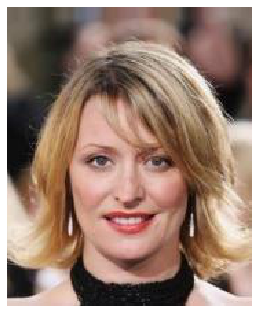

In [0]:
# Loading a pre-difined random image and plotting using the matplotlib Library.
random_image= load_img(example_im)
# Gets rid of the unwanted grid lines.
plt.grid(False)
# Gets rid of the unwanted y and x axes.
plt.xticks([]), plt.yticks([])
plt.imshow(random_image)
#some attributes
df_attr.loc[example_im.split('/')[-1]][['Smiling','Male','Young','Wearing_Earrings']] 
# 004387
# 009759

The recommended partitions by the CelebA dataset are displayed as follows:

*   Training set : 0
*   Validation set : 1
*    Test set : 2

The first five images seems to all belong to the training set.

In [0]:
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


The training set has 162,770 images, the validation set has 19,867 images and the test set contains 19,962 images within them.

In [0]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

The smiling attribute will be extracted for the smile classification task in section B of this notebook. We have joined the partitions with the smiling attribute for the first five images. 

In [0]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)

In [0]:
df_partition['partition'].value_counts().sort_index()
df_par_attr = df_partition.join(df_attr['Smiling'], how='inner')
df_par_attr.head()

,partition,Smiling
image_id,,
000001.jpg,0,1
000002.jpg,0,1
000003.jpg,0,0
000004.jpg,0,0
000005.jpg,0,0


It is vital to explore whether there exists an imbalance within the "smile" category. A significant class imbalance will perturb model towards the dominant class during training which increases the likelihood of inaccuracy in class prediction as the model tends to learn features that are more relevant to the dominant class. There are few possible strategies that can be used to combat dataset imbalance. One way is to shrink the dominant class by down sampling or otherwise to up-sample the smaller class by data augmentation to match up to the size of the more dominant class.  This notion only applies to the smile classification and not portrait segmentation task. The classification task can be performed for any of the forty attributes but here we have chosen the "smiling" category and as we can see there is not much imbalance within this attribute, thus neither of the mentioned techniques needs to be utilised.


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


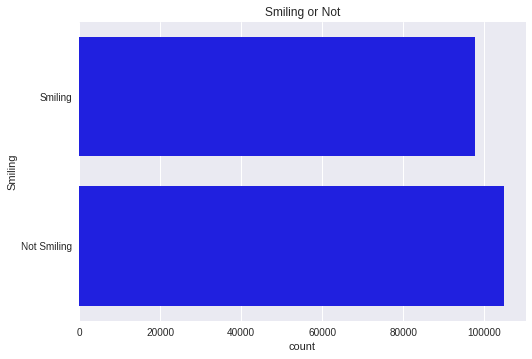

In [0]:
# Plotting the ratio between the Smiling and not similing attributes
# creating a deep copy of df_attr so that the 0 and 1 does not change in the main file.
df_copied_attr=copy.deepcopy(df_attr)
# replacing 1 and 0 with "Smiling" and "Not Smiling" respectively.
df_copied_attr.replace(to_replace=1 , value="Smiling", inplace=True)
df_copied_attr.replace(to_replace=0, value="Not Smiling", inplace=True)
# Plotting the histogram using Seaborn.
plt.title('Smiling or Not')
sns.countplot(y='Smiling', data=df_copied_attr, color="b")
plt.show()

The confusion matrix shows the relationship between attributions and their respective correlations. This may be important if we were using multiple number of the labels for a multi task learning model. However, as we are only using the "smile" class label, the information from the confusion matrix is not of much relevance. Nevertheless, it is quite important to study the relationships between the features of a dataset prior to applying any type of deep learning model.


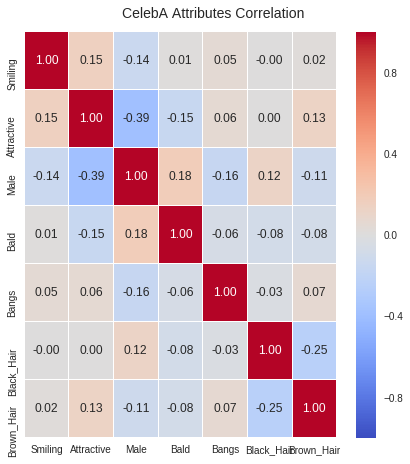

In [0]:
# set the size of the confusion matrix.
f, ax = plt.subplots(figsize=(7, 7))

# pick a sample of the attributes
subset_attr = ['Smiling', 'Attractive', 'Male', 'Bald', 'Bangs', 'Black_Hair', 'Brown_Hair']
corr = df_attr[subset_attr].corr()
# plot the matrix using seaborn
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('CelebA Attributes Correlation', fontsize=14)

#Transfer Learning

In context of the proposed challenges above, a common approach to a computer vision classification or segmentation task is to use a pre-existing model that has shown to result in reasonable accuracies. Thereby, the training set would be used for the model to learn underlying patterns and features from scratch. Tuning of the hyperparameters would be done on the validation set during the training session and finally the best saved weights would be used on the test set for the purposes of portrait segmentation or the prediction of the correct class label.  At first glance, this seems to be a logical approach to the task at hand however, this is computationally very expensive, will take a huge amount of time to train and will require a very large GPU. Hence, this approach is not the most optimal and efficient way to utilise available resources on Google Colab.

A better technique is to use transfer learning which uses already learnt features on a similar but separate large-scale datasets such as ImageNet (i.e. COCO weights from Microsoft) that have demonstrated to be an excellent resource for the task of transfer learning. These networks learn a set of rich, discriminating features to recognize 1,000 separate object classes. It makes sense that these filters can be reused for classification tasks other than what the CNN was originally trained on. There are two types of transfer learning when applied to deep learning for computer vision:

1. Treating networks as arbitrary feature extractors, meaning having a pre-trained CNN as feature extractor. Using this feature extractor, dataset of images is forward propagated through the network, the activations are extracted at a given layer and the values are saved.
2. Removing the fully-connected layers of an existing network, placing new fully connected layer set on top of the CNN, and fine-tuning these weights (and optionally previous layers) to recognize
object classes. 

The first approach is used in part A for portrait segmentation task and the second approach is in part B used for the Smile classification task.


# A) Portrait Segmentation
Portrait segmentation is a fundamental computer vision problem with many different applications. The algorithm entails of detecting the biggest object/s in an image as the foreground and discarding the rest of the image as the background. Models such as KNN-matting have comparatively 
poor performance when the foreground and background have similar colourings or abnormal textures, which can be due to their incapability of extracting high-level features. KNN-matting is also unable to detect the class of the object present in a given image. Impressively, Mask RCNN proposes a novel deep learning approach that does not share these issues. Of- course, there exists other novel methods such as "Deep image matting"  by Xu et al. , which we have not been implemented here but nevertheless is expected to perform extremely well on CelebA dataset.

Segmentation in general falls under semantic segmentation and instant segmentation. Unlike semantic segmentation, instant segmentation is capable of detecting the silhouette of the the detected object in addition of imposing the bounding box and the object accuracy score. As we can see, Mask RCNN which is a form of instant segmentation is not built for image matting tasks per se, nevertheless it is very much capable of performing the matting operation with very small tweaks to its model's architecture. Two things to notice is that Mask RCNN imposes one block-colour mask on top of the detected object plus the background of the image remains colourful. In this task instead of getting rid of the background completely, we will grey it out. Also, we will not impose a one block colour upon the segmented portrait and we will output it as a coloured mask. The final output will appear as though the background behind the celebrity’s silhouette has been greyed out without touching the natural colouring of the image of the celebrity itself. This is very much an image-matting/portrait segmentation operation without using the common image-matting algorithms. 








## 1A) Image Pre-proccessing:

The portrait segmentation task is started after getting a good understanding of the CelebA dataset. We first begin by creating two function "load_img" and "generate_df" that help us load and pre-process the data.

It is good to note that the image processing libraries such as OpenCV and Scikit-image represent RGB (Red-Green-Blue) images as multidimensional Numpy arrays with shape (height, width, depth) instead of (width, height, depth) due to their inherited matrix notation. This is a *common catch* to be aware of. 

The Keras library provides the "img_to_array" function that accepts an input image and properly orders the channels. It efficiently prepares the images for training, validation and testing. Hence "load_reshape_img" function returns a new Numpy array with the channels properly ordered. The benefit of defining a function to handle this type of image pre-processing rather than simply calling img_to_array on every single image is that we can now chain pre-processors together as we load datasets from Kaggle.


Moreover, the raw pixel intensities are scaled since RGB coloured channels' intensity ranges from 0 to 255. The division by 255 handles normalizing raw pixel intensity values to the range 0 to 1. The motivation behind scaling the pixel intensities is to achieve consistencies for all the images in the dataset.





In [0]:
def load_img(fname):
#   Load the images
    img = load_img(fname)
#   Normalise pixel intensity 
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    return x

The function "generate_df" loops over the images withing the dataset and prepares it for the portrait segmentation task. There are three main catches to notice here. The first is the nature of the cv2.imread from OpenCV where height of the image is passed before its width. This is consistent with how OpenCV access values in a matrix. First by specifying the row number then the column number. From there, we are given a tuple representing the three channel components of the image i.e. the depth of the image. 

The second point to take note of is that OpenCV stores RGB channels in reverse order. This is where the normal convention is Red, Green and Blue. OpenCV stores the pixel values in Blue, Green and Red order. This is because early developers of the OpenCV library chose the BGR colour format due to its popularity amongst camera manufacturers at the time. It’s a small caveat to keep in mind when working with OpenCV. This problem is remedied by using the cv2.cvtColor wrapper and setting it to cv2.COLOR_BGR2RGB . Failure to do this results into blue images.






In [0]:
def generate_df(df_, num_samples):
    x_ = []  

    for index, target in df_.iterrows():
#       reading the images folder
        im = cv2.imread(images_folder + index)
#       changing the BGR colour channels to conventional RGB ordering.        
        im= cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        x_.append(im)
        

    return x_

Google Colab is unable to process more than 200 images otherwise its RAM exceeds its limit and the notebook resets. It is important to note the accuracy of the outcome of the portrait segmentation model is linked to the how well the pre-trained weights respond to detecting a person in an image. Hence, the number of images passed through the algorithm is a redundant factor as it is not related to the final accuracy. Therefore, for simplicity and demonstration of the core idea of the task at hand, we will only pass 100 images at this stage.



In [0]:
# Segmenting the dataset.
original_image ,y_label= generate_df(no_samples)
len(original_image)

100

The loop in the cell below helps to visualize the first ten images within the original_image set. This will be a good reference point for comparison once the portrait segmentation process is over. As expected the shape of the coloured images is (218, 178, 3) which are respectively the height, width and the depth/number of channels of each image.


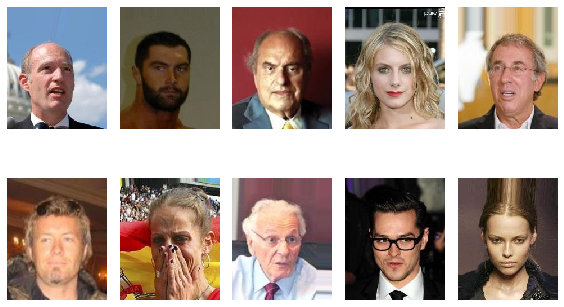

'The shape of the coloured images is (218, 178, 3).'

In [0]:
# seeing the first 10 images in the 100 batch.
k=0

for k_image in original_image[0:10]:
  plt.subplot(2,5, k+1)
  plt.grid(False)
  plt.xticks([]), plt.yticks([])
  plt.imshow(k_image.reshape(218,178,3))  
  if k==11:
    break
  k+=1
plt.tight_layout()   
plt.show()
  
f"The shape of the coloured images is {k_image.shape}."

Another pre-processing step includes grey scaling the batch of images and saving them in a new container i.e. "gray_image_data". These images will be needed later on in "apply_mask" function. The grey scaling conversion is done by using the "cv2.COLOR_BGR2GRAY" function from the OpenCV library. By printing the the shape of the grey images we can see that there is no depth to these images. i.e. the depth is 1. Grey images only need one channel that outputs different intensities between white and black. We will see later that the segmented portrait masks will be superimposed on top of these grey images. However, the coloured masks will have depth of three channels while the the grey images will only have one channel which will be problematic. This mismatch between the shapes of the images will be corrected in the "apply_mask" function.


In [0]:
# saving the gray-scaled images in gray_image_data container.

gray_image_data=[]

for i in original_image:
#   Changes the original coloured images to gray-scaled images
  gray_images = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
#   gray_images=img_to_array(gray_images)
  gray_images=np.reshape(gray_images,(218,178))
  gray_image_data.append(gray_images)
  
  
f"The shape of the gray images is {gray_images.shape}."
  

'The shape of the gray images is (218, 178).'

We have plotted the grey-scaled images to observe whether the previous loop has worked properly. The images are indeed in the correct format.

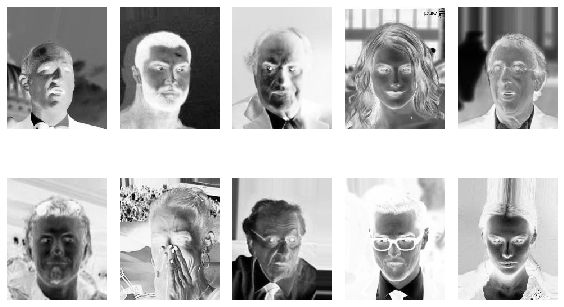

In [0]:
# plotting the gray-scaled format of the respective image.

m=0
for m_image in gray_image_data[0:10]:
  plt.subplot(2,5,m+1)
  plt.xticks([]), plt.yticks([])
  plt.grid(False)
  plt.imshow(m_image.reshape(218,178))
  if m==11:
    break
  m+=1  
plt.tight_layout() 
plt.show()

In the cell below we have performed deep copy of both original colour images and the grey_scaled images. There are two main points to note here. Firstly, when the Mask RCNN is applied later on, it changes the original lists to masked images. It is a better practice to keep the original lists unchanged and create new copies to perform the portrait segmentation task on. Secondly, the "copy.copy" function has two different modalities. The default modality is shallow copying of the given list and the second modality is the deep copy which we have used here. The "copy.shallowcopy" inserts *references* into it to the objects found in the original lists while "copy.deepcopy" inserts *copies* into it of the objects found in the original lists. If shallow copy is used, the copied lists will still be linked to the original lists. Hence, any changes to the copied lists will simultaneously change the original lists as it creates copies using references. The deep copy modality is used instead as it completely separates the copied lists from the original lists. Therefore, in the event of producing masked images the original sets will remain unchanged. 

Lastly, we will double check the length of the lists to make sure that the deep copy has been successful.


In [0]:
# Duplication of both original coloured images and gray list
coloured_list=copy.deepcopy(original_image)
gray_list=copy.deepcopy(gray_image_data)
f"The length of the coloured_list is {len(coloured_list)} and the length of the gray_list is {len(gray_list)}."

'The length of the coloured_list is 100 and the length of the gray_list is 100.'

## 2A) Core Model


Common Objects in Context (COCO) is a database that aims to enable research for object detection, instance segmentation and image captioning. We start by downloading weights to the correct directory. Note that COCO dataset is trained to predict about 90 different labels which are printed in later cells but we will only use the "person" label for the purposes of this task as the other labels are irrelevant for the CelebA dataset. Notice the ".h5" at the end of the "mask_rcnn_coco.h5" while loading/downloading the weights. This is a form of HDF5 files. They are a binary data format created by the HDF5 group that store gigantic numerical datasets. They facilitate easy access and computation on the rows of the datasets and data stored in HDF5 is hierarchical. Data is first defined in groups, where a group is a container-like structure which can hold datasets and other groups. Once a group has been defined, a dataset can be created within the group. A dataset can be
thought of as a multi-dimensional array (i.e.,a Numpy array) of a homogeneous data type (integer, float, unicode, etc.).




In [0]:
# Load/Download pre-trained coco weights.
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [0]:
# Change the config inferance
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    
    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 1
    
config = InferenceConfig()

Mask RCNN is an example of instance segmentation model developed by He et al. at Facebook. It allows to identify pixel wise locations of the target classes hence it masks on the silhouette of the object as well as output a bounding box otherwise it is quite similar to the Faster RCNN. 

The selective search algorithm is used to find the regions of proposals and then a single CNN is used to classify the object class and the offset values for the bounding boxes which means that the selective search and the detection networks are decoupled. For instance, if the selective search sends a false negative region of proposal to the feature extraction network, it can directly affect the detection network. Hence, coupling them in a manner that they correlate to each other is a better idea. The model improves upon the selective search which speeds up the time on the test examples significantly. Instead of using the selective search algorithm on the convolutional feature map, a separate network is used to identify regions of proposal.

Firstly, the image is fed into the convolutional layer to extract a feature map from it. Then a sliding window is used in regions of proposal network for each location over the feature map. For each location K anchor boxes are used to generate the regions of proposals. The classification layer outputs 2K scores to identify whether or not an object is present within the K boxes. The regression layer outputs 4K for the coordinates of the k boxes. Hence the region of proposal network is there to pre-check whether an object is present or not within an anchor box before sending it to the detection network. These regions of proposals are then shaped using is RoI (Region of Interest) pooling layer and is sent to the SVM to classify the object within these regions and to predict the offset values of the bounding boxes. 

Mask RCNN outputs, the class probability and the offset values for the bounding box and a third score that is the object's mask which is a binary mask that indicates which pixels in the bounding box are of the detected object. This addition is much more distinct that the class label and the bounding box and requires finer spatial layout of the object. Mask RCNN uses fully convolutional network for semantic segmentation. It combines various convolutional operations and max pooling layers to firstly reduce the size of the image to approximately 1/32 of its original size. The class probability is predicted at this level. Up-sampling and deconvolution is used to re-size the image back to its original dimensions. The loss function is an average of object detection, bounding box and object masking. 

Mask RCNN's mode is switched to "inference" meaning that the model will only be using CelebA dataset as a test set and it uses the COCO weights as if the model has been trained on the ImageNet dataset. Note that we will only use the "person" label from the COCO weights is used for the purposes of this task as the other labels are irrelevant for the CelebA dataset. Furthermore, the "by_name" option is set to true in model.load_weights to load the weights for the layers with matching name as the saved model.





In [0]:
# loading Mask RCNN in inference modality. 

model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)
class_names = [
    'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


This function is used to change the colourful background information to grey-scale and tackle the miss match between the shapes of the grey images and the coloured masks. 

*   "image[:,:,0]" is the Blue channel
*   "image[:,:,1]" is the Green channel
*   "image[:,:,2]" is the Red channel

"mask == 0" means that this pixel does not belong to the foreground and "np.where" function changes the pixel its gray_image equivalent if it belongs to background.
Since the grey image is 2 dimensional and has no depth, for each pixel in background, we set 3 channels to the same value to make the grey-scale image have the same shape as the coloured image.

In [0]:
def apply_mask(images,gray, mask):  
    images[:, :, 0] = np.where(mask == 0,gray[:, :],images[:, :, 0])
    images[:, :, 1] = np.where(mask == 0,gray[:, :],images[:, :, 1])
    images[:, :, 2] = np.where(mask == 0,gray[:, :],images[:, :, 2]) 
    return images

The "display_instances" function is taken from utility.py file from the Mask RCNN model on the github. It is then slightly modified to fit our purpose. Note that normal version of the Mask RCCN model imposes a one coloured mask on the detected objects and leaves the background colourful but this is not our desired outcome. The "display_instances" function needs to be changed so that it outputs the cropped silhouette image of the person and imposes that on top of the grey-scaled image. Hence it appears as though the background has turned grey. This is done by simply using our "applied_mask" function outside the last loop.

In [0]:
# This function is used to show the object detection result in original image.
def display_instances(image_in, gray_image,  boxes, masks, ids, names, scores):
    # max_area will save the largest object for all the detection results
    max_area = 0
    
    # n_instances saves the amount of all objects
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue

        # compute the square of each object
        y1, x1, y2, x2 = boxes[i]
        square = (y2 - y1) * (x2 - x1)

        # use label to select person object from all the 80 classes in COCO dataset
        label = names[ids[i]]
        if label == 'person':
            # save the largest object in the image as main character
            # other people will be regarded as background
            if square > max_area:
                max_area = square
                mask = masks[:, :, i]
            else:
                continue
        else:
            continue

    # apply mask for the image
    
    image_out = apply_mask(image_in,gray_image, mask)
     
    return image_out
  

This is the main loop that brings all the functions together and performs masking of the batch of images. First, human detection is done on the coloured images where it roughly finds the outline of the person and crops it as the foreground of the image. Second, these cropped coloured masks are superimposed upon their respective grey images.


In [0]:
# where we concatanate the mask onto the gray scaled image.
scores=[]

for masked_image, gray_ in zip(coloured_list, gray_list):

#  This function is from the MRCNN, which deos the job of detection. 
  results = model.detect([masked_image], verbose=0)
#  we only want the masks

  r = results[0] 
  frame = display_instances(masked_image, gray_, r['rois'], r['masks'], 
                            r['class_ids'], class_names, r['scores']) 
  scores.append(r['scores'])


print('done')


done


## 3A) Evaluation of Results

Here we will extract the average of the scores per image. The point to note here is that Mask RCNN has no way of knowing how accurate the imposed mask is. This is because there are no verified ground truth images for the CelebA datasets as for most other large image datasets. To truly know the accuracy of a given mask, we need to manually extract and label the background and foreground pixels. As mentioned before this is hugely labour intensive and time consuming. Hence, according to research that I have undertaken, there is no solid measure of accuracy of the segmented tasks. The scores that are extracted here are the confidence of the model of how accurate the bounding boxes are located over the detected object.


In [0]:
average=[]
for i in scores:
  ave=i.mean()
  print(ave)
  average.append(ave)


As mentioned before, there is no training involved in this style of transfer learning and the image dataset that is passed to the model is treated as a test set. In the chart that follows depicts the confidence of the model for the each input image.

The confidence plotted in the graph below is an indication of the model’s confidence of how tightly each mask is imposed upon the foreground region of interest. As we can see the confidence scores range from 0.83 to 1.00. It is important to note that if the original model were to be trained on CelebA dataset or a dataset very similar to it (such as the Smiles dataset), we would expect confidence scores starting from 0.95 to 1.00. This is because that during training session,  the model learns a distribution from the underlying images and assumes data are independently and identically distributed. If the two datasets are not a greatly matched, then the learnt features on the original dataset may not respond very well to our dataset. This point is explained in more depth below.




Text(0.5, 1.0, 'Model Confidence Score For First 100 Images')

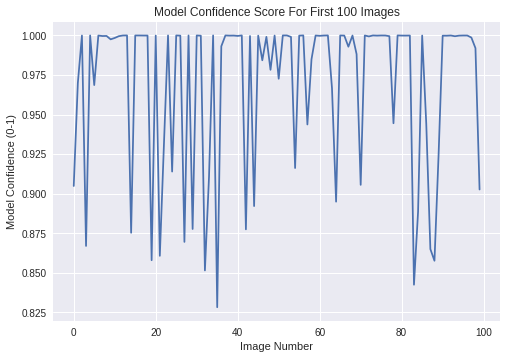

In [0]:
plt.plot(average,label='score')
plt.xlabel('Image Number')
plt.ylabel('Model Confidence (0-1)')
plt.title ('Model Confidence Score For First 100 Images')


We can better observe the performance of the Mask RCNN model by printing the images after they have been transformed from colourful images to masked images.


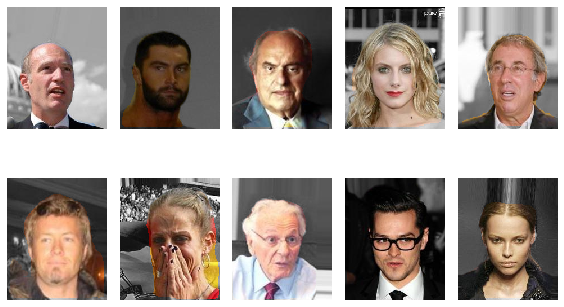

In [0]:
# only first 10 pictures are shown
f=0

for i_masked in coloured_list[0:10]:
  
  
  plt.subplot(2,5, f+1)
  plt.grid(False)
  plt.xticks([]), plt.yticks([])
  plt.imshow(i_masked.reshape(218,178,3))
  
  if f==16:
    break
  f+=1
    
plt.tight_layout()  
plt.show()

 

As we can see all the images have been segmented very accurately except for one of them. This maybe because of the fact that the woman is holding her hands in front of her mouth. Hence, the Mask RCNN algorithm is unable to fully extract the regions of interest as it sees two eyes and no mouth. Interestingly, the pixels that ought to have been cropped out are within the vicinity of the person's mouth. As Andrew Ng’s stated in one of his talk:

>*“Most issues in applied deep learning come from training data/testing data mismatch. In some scenarios this issue just doesn’t come up, but you’d be surprised how often applied machine learning projects use training data (which is easy to collect and
annotate) that is different from the target application". *

In deep learning, as the model sees the training data, it assumes an identical independent distribution and maps the input images to a given distribution. While testing the data, the model assume that the unseen images come from the same distribution as before. The closeness between the dataset that the saved weights were trained on and the dataset we are implementing the weights on is of great significance as they need to come from a similar distribution. An honest analysis between the similarity of the COCO and CelebA datasets needs to be undertaken and thus, have tabulated the difference between the two datasets:


>COCO dataset | CelebA dataset
>--- | ---
>1.5 million images | 202,599 images 
> 90 catagories | 40 attributes
>  5 captions per image | 40 captions per image

Note that the categories in the COCO dataset indicate different classes of objects within a given image while there exists only one object class i.e. person for CelebA dataset. The 40 different attributes captioned for the CelebA dataset are all human-related. The person class in the COCO dataset responds to ranges between cropped faces to full body size images. As we can see the COCO dataset is indeed valuable for this task however it has its shortcomings as a small percentage of its images correspond to CelebA dataset. 

Moreover, we have selected only one class label out of the available 90 in the COCO dataset. This means that while COCO model was training, its weights had to respond to a much wider range of classes, meaning that the weights that get activated when there is a person within the image is not as strong as it would have been if COCO was an only human dataset. This is maybe another reason as why some images have their accuracies as low as 84% and some images such as the female above have small part of their background labelled at the foreground.

In spite of that, Mask RCNN had a satisfactory  performance, given the shortcomings that were presented to it and has outputted accuracies between 98-100% on majority of images and mid 80s on a minority of images. Moreover, Deep Image Matting developed by Xu et al., can be performed to create a comparative bench mark for the instant segmentation model. 
 
